In [ ]:
# Final EE vs ramp time (T_cut) for J in {2,1,0.5} — styled like previous figs

import numpy as np
import qutip as qt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pathlib import Path
from datetime import datetime
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec

# ====== Matplotlib: presentation style (big labels, inward ticks) ======
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams.update({
    "axes.labelsize": 18,   # 軸ラベル
    "xtick.labelsize": 16,  # 目盛り数字
    "ytick.labelsize": 16,
    "lines.linewidth": 2.2, # 線の太さ
    "axes.titlesize": 16,
})

# ---- helpers (same vibe as earlier figs) ----
def label_right_of_last(ax, x, y, text, *, dx_pt=8, fontsize=16):
    """
    曲線の最後の点 (x[-1], y[-1]) の『右側』に、同じ高さでラベルを置く。
    - dx_pt: 右方向オフセット（ポイント）
    """
    ax.annotate(
        text,
        xy=(x[-1], y[-1]),
        xytext=(dx_pt, 0), textcoords="offset points",
        ha="left", va="center",
        fontsize=fontsize,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.7, lw=0),
        path_effects=[pe.withStroke(linewidth=3, foreground="white")],
        clip_on=False,  # 右端に少しはみ出しても切れないように
        zorder=5,
    )
    
def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True,
                   length=major_len, width=width)
    ax.tick_params(which="minor", length=minor_len, width=width)

def _screen_angle(ax, x, y, i):
    trans = ax.transData.transform
    i0, i1 = max(i-1, 0), min(i+1, len(x)-1)
    (x0, y0) = trans((x[i0], y[i0])); (x1, y1) = trans((x[i1], y[i1]))
    return np.degrees(np.arctan2(y1-y0, x1-x0))

# ====== Model / lattice ======
Lx, Ly, cut_pos = 4, 4, 2
N = Lx * Ly
delta = 1.0
T_total, nt = 10.0, 200
tlist = np.linspace(0.0, T_total, nt)
idx = lambda x, y: y * Lx + x

# Bonds
def nn_bonds_4x4():
    B = []
    for y in range(Ly):
        for x in range(Lx):
            if x + 1 < Lx: B.append((idx(x,y), idx(x+1,y)))
            if y + 1 < Ly: B.append((idx(x,y), idx(x,y+1)))
    return [tuple(sorted(b)) for b in B]

bonds_all = nn_bonds_4x4()
cut_list   = [(idx(1,y), idx(2,y)) for y in range(Ly)]
keep_bonds = [b for b in bonds_all if b not in cut_list]

# Operators & unit Hamiltonians (J=1)
sx, sy, sz = [0.5*M for M in (qt.sigmax(), qt.sigmay(), qt.sigmaz())]
I2 = qt.qeye(2)
def op_at(i, op): return qt.tensor([op if k==i else I2 for k in range(N)])
S = [(op_at(i,sx), op_at(i,sy), op_at(i,sz)) for i in range(N)]
def H_bond_unit(i,j, delta=delta):
    Sxi,Syi,Szi = S[i]; Sxj,Syj,Szj = S[j]
    return (Sxi*Sxj + Syi*Syj + delta*Szi*Szj)

H_keep_unit  = sum(H_bond_unit(i,j) for (i,j) in keep_bonds)
Hm_unit_list = [H_bond_unit(i,j) for (i,j) in cut_list]
H_all_unit   = H_keep_unit + sum(Hm_unit_list)

# Ramp profile
def c_ramp(t, T_cut):
    if T_cut <= 0.0: return 1.0 if t <= 0.0 else 0.0
    if t <= 0.0:     return 1.0
    if t >= T_cut:   return 0.0
    return 1.0 - t/T_cut

# Time-dependent Hamiltonian for (T_cut, J)
def make_H_time(T_cut: float, J: float):
    H_t = [J * H_keep_unit]
    def coeff(t, args=None): return J * c_ramp(t, T_cut)
    for Hm in Hm_unit_list:
        H_t.append([Hm, coeff])
    return H_t

# Initial state: ground state of H_all(J=1)
_, psi_ground = H_all_unit.groundstate(sparse=True)

# Entanglement Entropy on left half
left_sites = [idx(x,y) for y in range(Ly) for x in range(cut_pos)]
def EE_op(t, state, args=None):
    rhoL = qt.ptrace(state, left_sites)
    return float(qt.entropy_vn(rhoL, base=2))  # bits

solver_opts = dict(store_states=False, progress_bar=None,
                   rtol=1e-6, atol=1e-8, nsteps=20000)

def run_EE_final(T_cut: float, J: float, psi0):
    H_t = make_H_time(T_cut, J)
    sol = qt.sesolve(H_t, psi0, tlist, e_ops=[EE_op], options=solver_opts)
    return np.array(sol.expect[0])[-1]

def run_EE_curve(T_cut: float, J: float, psi0):
    H_t = make_H_time(T_cut, J)
    sol = qt.sesolve(H_t, psi0, tlist, e_ops=[EE_op], options=solver_opts)
    return np.array(sol.expect[0])

# ====== Sweep settings ======
T_ramps = [i*0.5 for i in range(21)]   # 0.0 ... 10.0 (step 0.5)
J_list  = [2.0, 1.0, 0.5]

# ====== Compute final EE for each (T_cut, J) ======
final_EE = {J: [] for J in J_list}
for J in J_list:
    for T_cut in T_ramps:
        final_EE[J].append(run_EE_final(T_cut, J, psi_ground))

saved: charts/20250923-100755/final_SA_vs_Tcut.pdf


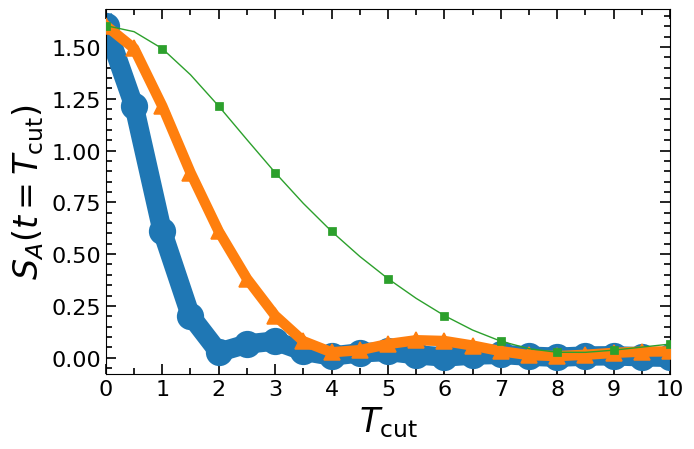

In [ ]:
# ---- 直書きラベル（凡例ボックスなし・重なり回避つき） ----
import matplotlib.patheffects as pe
import numpy as np

# ==== 追加: 手置きラベル用ヘルパ（凡例ボックスなし） ====
import matplotlib.patheffects as pe

def label_at(ax, x, y, text, *, coord='data', dx_pt=8, fontsize=14, color=None):
    """
    (x,y) にラベルを直接配置。
      coord='data'  -> データ座標
      coord='axes'  -> 軸比率座標 (0..1, 左下=0,0)
    dx_pt: 右方向の微小オフセット[pt]（線と重なりを避ける）
    """
    kw = dict(ha='left', va='center', fontsize=fontsize,
              xytext=(dx_pt, 0), textcoords='offset points',
              path_effects=[pe.withStroke(linewidth=3, foreground='white')],
              clip_on=False, zorder=6)
    if color is not None:
        kw['color'] = color
    if coord == 'axes':
        ax.annotate(text, xy=(x, y), xycoords=ax.transAxes, **kw)
    else:
        ax.annotate(text, xy=(x, y), xycoords='data', **kw)

# ====== (1) Final EE vs T_cut J全部 ======
# 好きな位置にどうぞ（データ座標）
pos1 = { 2.0: (1.35, 0.3),   # (x=Tc, y=Final S_A)
         1.0: (2.2, 0.65),
         0.5: (3.2, 1.0)}

fig1, ax1 = plt.subplots(figsize=(6.9, 4.6))
inward_ticks(ax1)
markers = ['o', '^', 's'] 

n = len(J_list)

# 裏→表 で 大→小 に線形に変化
max_lw, min_lw = 14.0, 1.0       # 線の太さ
max_ms, min_ms = 18.0, 6.0      # マーカーサイズ
max_pts, min_pts = 20, 10        # マーカー点数（上限20想定）
# alpha_back, alpha_front = 0.95, 0.90  # 透明度（任意）

lw_seq    = np.linspace(max_lw,  min_lw,  n)
ms_seq    = np.linspace(max_ms,  min_ms,  n)
npts_seq  = np.linspace(max_pts, min_pts, n).round().astype(int)
# alpha_seq = np.linspace(alpha_back, alpha_front, n)

# 複数のJ
for i, J in enumerate(J_list):
    x = T_ramps; y = final_EE[J] 
    mk = markers[i % len(markers)]
    step = max(1, len(x) // max(1, npts_seq[i]))
    ln, = ax1.plot(
        x, y,
        marker=mk,
        linewidth=lw_seq[i],
        markersize=6.0,          # 裏ほど大→表ほど小
        markeredgewidth=0.9 * (ms_seq[i] / 10),   # 見栄え調整（任意）
        # alpha=alpha_seq[i],
        markevery=step,
        zorder=2 + i,)              # 表ほど手前),           
    # label_at(ax1, *pos1[J], fr"$J={J:g}$",
             # coord='data', fontsize=18)      # ← label付けない

# # 単一のJ
# J = 1.0
# x = T_ramps; y = final_EE[J]
# ln, = ax1.plot(x, y, marker='o')            # ← label付けない
# label_at(ax1, *pos1[J], fr"$J={J:g}$",
#          coord='data', fontsize=18)

ax1.set_prop_cycle(color=plt.cm.tab10.colors)
ax1.set_xlim(0.0, 10.0)
ax1.set_xlabel(r"$T_{\mathrm{cut}}$", fontsize=24)
ax1.set_ylabel(r"$S_A(t = T_{\mathrm{cut}})$", fontsize=24)
ax1.set_title("")
ax1.xaxis.set_major_locator(MultipleLocator(1.0))
ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
x = np.asarray(x, dtype=float)
y = np.asarray(y, dtype=float)
# mask = (x <= 4)  # 0〜4 の範囲だけ
# ax1.fill_between(
#     x, y, 0,                       # 曲線とx軸(=0)の間
#     where=mask,                    # 0〜4 のみ
#     interpolate=True,              # 4 できっちり境界にする
#     facecolor='none',              # 斜線だけにしたい場合
#     hatch='///',                   # 斜線（'\\\\', 'xx' なども可）
#     edgecolor='0.4', linewidth=0,  # 斜線の色・線幅
#     zorder=0                       # 曲線より背面に
# )
fig1.tight_layout()

# # ====== (1') Rescaled: Final EE vs (J*T_cut) ======
# # こちらも手置き（データ座標：横軸は J*Tc）
# pos2 = { 2.0: (1.4, 1.05),
#          1.0: (1.9, 0.80),
#          0.5: (2.3, 0.60) }

# fig2, ax2 = plt.subplots(figsize=(6.9, 4.6))
# inward_ticks(ax2)

# n = len(J_list)
# # 裏→表 で 大→小 に線形に変化
# max_lw, min_lw = 14.0, 1.0       # 線の太さ
# max_ms, min_ms = 18.0, 6.0      # マーカーサイズ
# max_pts, min_pts = 20, 10        # マーカー点数（上限20想定）
# alpha_back, alpha_front = 0.95, 0.90  # 透明度（任意）

# lw_seq    = np.linspace(max_lw,  min_lw,  n)
# ms_seq    = np.linspace(max_ms,  min_ms,  n)
# npts_seq  = np.linspace(max_pts, min_pts, n).round().astype(int)
# alpha_seq = np.linspace(alpha_back, alpha_front, n)

# for J in J_list:
#     x = [Tc * J for Tc in T_ramps]; y = final_EE[J]
#     mk = markers[i % len(markers)]
#     step = max(1, len(x) // max(1, npts_seq[i]))
#     ln, = ax2.plot(
#         x, y, 
#         marker=mk,
#         linewidth=lw_seq[i],
#         markersize=ms_seq[i],                     # 裏ほど大→表ほど小
#         markeredgewidth=0.9 * (ms_seq[i] / 10),   # 見栄え調整（任意）
#         alpha=alpha_seq[i],
#         markevery=step,)
#     label_at(ax2, *pos2[J], fr"$J={J:g}$",
#              coord='data', fontsize=16)


# ax2.set_prop_cycle(color=plt.cm.tab10.colors)
# ax2.set_xlabel(r"$J T_{\mathrm{cut}}$", fontsize=16)
# ax2.set_ylabel(r"$Final S_A$", fontsize=16)
# ax2.set_title("")
# ax2.xaxis.set_major_locator(MultipleLocator(1.0))
# ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
# fig2.tight_layout()

# # ====== (2) Stacked: sweep T_cut ∈ {0.0, 2.5, 5.0} at fixed J ======
# from matplotlib.gridspec import GridSpec
# T_cut_list = [0.0, 2.5]
# J_fixed    = 1.0
# EE_curves_T = {Tc: run_EE_curve(Tc, J_fixed, psi_ground) for Tc in T_cut_list}

# # style = 'steps-post' if Tc == 0.0 else '-' 

# # 軸比率座標で手置き（0..1）。必要に応じて調整してください
# pos_top = { 0.0: (0.01, 0.4),
#             2.5: (0.22, 0.4),
#             5.0: (0.50, 0.4) }

# pos_bot = { 0.0: (0.20, 0.80),
#             2.5: (0.40, 0.32),
#             5.0: (0.55, 0.12) }

# fig3 = plt.figure(figsize=(7.2, 6.4))
# gs = GridSpec(2, 1, height_ratios=[1, 3], hspace=0.1)
# ax_top = fig3.add_subplot(gs[0, 0])
# ax_bot = fig3.add_subplot(gs[1, 0], sharex=ax_top)
# inward_ticks(ax_top); inward_ticks(ax_bot)

# # --- Top
# for Tc in T_cut_list:
#     Jt = [J_fixed * c_ramp(t, Tc) for t in tlist]
#     ax_top.plot(tlist, Jt,lw=3,
#         marker='o',
#         markersize=5,
#         markevery=5,      # ドットの間引き（ポイント数に応じて調整）
#         zorder=3,)
#     # label_at(ax_top, *pos_top[Tc], rf"$T_{{\mathrm{{cut}}}}={Tc:g}$",
#     #          coord='axes', fontsize=8)
#     if Tc > 0: ax_top.axvline(Tc, ls=":", lw=1.2, alpha=0.6)

# ax_top.set_prop_cycle(color=plt.cm.tab10.colors)
# ax_top.set_xlim(0.0, 10.0)
# ax_top.set_ylim(-0.35, 1.15)
# ax_top.set_ylabel(r"$J'(t)$",fontsize=24)
# ax_top.tick_params(labelbottom=False)
# ax_top.set_title("")

# # --- Bottom
# for Tc in T_cut_list:
#     St = EE_curves_T[Tc]
#     ln, = ax_bot.plot(tlist, St, lw=3,
#         marker='o',
#         markevery=5,      # ドットの間引き（ポイント数に応じて調整）
#         markersize=5,
#         zorder=3,)
#     label_at(ax_bot, *pos_bot[Tc], rf"$T_{{\mathrm{{cut}}}}={Tc:g}$",
#              coord='axes', fontsize=20)
#     if Tc > 0: ax_bot.axvline(Tc, ls=":", lw=1.2, alpha=0.6)

# ax_bot.set_prop_cycle(color=plt.cm.tab10.colors)
# ax_bot.set_xlim(0.0, 10.0)
# ax_bot.set_xlabel(r"$t$", fontsize=24)
# ax_bot.set_ylim(0.0, 1.75)
# ax_bot.set_ylabel(r"$S_A(t)$", fontsize=24)
# ax_bot.spines['top'].set_alpha(0.45)
# ax_bot.spines['top'].set_linewidth(1.0)

# fig3.tight_layout()

# # ====== (2') Stacked: sweep T_cut = 0.0 at fixed J ======
# from matplotlib.gridspec import GridSpec
# Tc = 0.0
# J_fixed    = 1.0
# EE_curves_T = {Tc: run_EE_curve(Tc, J_fixed, psi_ground) for Tc in T_cut_list}

# # 軸比率座標で手置き（0..1）。必要に応じて調整してください
# pos_top = { 0.0: (0.02, 0.4),
#             2.5: (0.22, 0.4),
#             5.0: (0.50, 0.4) }

# pos_bot = { 0.0: (0.20, 0.85),
#             2.5: (0.40, 0.28),
#             5.0: (0.55, 0.12) }

# fig4 = plt.figure(figsize=(7.2, 6.4))
# gs = GridSpec(2, 1, height_ratios=[1, 3], hspace=0.1)
# ax_top = fig4.add_subplot(gs[0, 0])
# ax_bot = fig4.add_subplot(gs[1, 0], sharex=ax_top)
# inward_ticks(ax_top); inward_ticks(ax_bot)

# # --- Top
# Jt = [J_fixed * c_ramp(t, Tc) for t in tlist]
# ln, = ax_top.plot(tlist, Jt,  color='C0',lw=3,
#     drawstyle="steps-post",
#     marker='o',
#     markersize=5,
#     markevery=5,      # ドットの間引き（ポイント数に応じて調整）
#     zorder=3,)
# label_at(ax_top, *pos_top[Tc], rf"$T_{{\mathrm{{cut}}}}={Tc:g}$",
#          coord='axes', fontsize=18)
# if Tc > 0: ax_top.axvline(Tc, ls=":", lw=1.2, alpha=0.6)

# ax_top.set_prop_cycle(color=plt.cm.tab10.colors)
# ax_top.set_xlim(0.0, 10.0)
# ax_top.set_ylim(-0.35, 1.15)
# ax_top.set_ylabel(r"$J'(t)$",fontsize=24)
# ax_top.tick_params(labelbottom=False)
# ax_top.set_title("")

# # --- Bottom
# St = EE_curves_T[Tc]
# ln, = ax_bot.plot(tlist, St, color='C0',lw=3,
#     drawstyle="steps-post",
#     marker='o',
#     markevery=5,      # ドットの間引き（ポイント数に応じて調整）
#     markersize=5,
#     zorder=3,)
# label_at(ax_bot, *pos_bot[Tc], rf"$T_{{\mathrm{{cut}}}}={Tc:g}$",
#          coord='axes', fontsize=18)
# if Tc > 0: ax_bot.axvline(Tc, ls=":", lw=1.2, alpha=0.6)

# ax_bot.set_prop_cycle(color=plt.cm.tab10.colors)
# ax_bot.set_xlim(0.0, 10.0)
# ax_bot.set_xlabel(r"$t$", fontsize=24)
# ax_bot.set_ylim(0.0, 1.75)
# ax_bot.set_ylabel(r"$S_A(t)$", fontsize=24)
# ax_bot.spines['top'].set_alpha(0.45)
# ax_bot.spines['top'].set_linewidth(1.0)

# fig4.tight_layout()

# ====== Save all ====== 
# TS = datetime.now().strftime("%Y%m%d-%H%M%S") 
# OUTDIR = Path("charts") / TS 
# OUTDIR.mkdir(parents=True, exist_ok=True) 
# def save_fig(fig, stem: str):
#     fig.savefig(OUTDIR / f"{stem}.pdf", bbox_inches="tight", dpi=300) 
#     print(f"saved: {OUTDIR / (stem + '.pdf')}") 

# save_fig(fig1, "final_SA_vs_Tcut") 
# save_fig(fig2, "final_SA_vs_JTcut") 
# save_fig(fig3, "stacked_t_and_S_t") 
# save_fig(fig4, "stacked_Jt_and_S_t") 
plt.show() # ここで一度だけ表示 plt.close('all') # ← これで自動描画の“もう一回”を防ぐ